In [1]:
from tqdm import tqdm
import cv2
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import pickle

In [2]:
# Check GPU available
#tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

Found GPU at: /device:GPU:0


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 10877778218757938256,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 7859600245935066641
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 16030513751193776562
 physical_device_desc: "device: XLA_GPU device",
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11235482010
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 10717290859180196701
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

In [3]:
submission=pd.read_csv('./sample_submission.csv')
train=pd.read_csv('./train.csv')
test=pd.read_csv('./test.csv')

# train.head()
# test.head()
# submission.head()

# Load training set
train_img=[]
train_label=[]
path='./images'
for im in tqdm(train['image_id']):
    im=im+".jpg"
    final_path=os.path.join(path,im)
    img=cv2.imread(final_path)
    img=cv2.resize(img,(224,224))
    img=img.astype('float32')
    train_img.append(img)

# Load test set
test_img=[]
path='./images'
for im in tqdm(test['image_id']):
    im=im+".jpg"
    final_path=os.path.join(path,im)
    img=cv2.imread(final_path)
    img=cv2.resize(img,(224,224))
    img=img.astype(('float32'))
    test_img.append(img)

100%|██████████| 1821/1821 [01:22<00:00, 22.18it/s]


In [4]:
# Create training labels
train_label=train.loc[:,'healthy':'scab']
train_img=np.array(train_img)
test_img=np.array(test_img)
train_label=np.array(train_label)

print(train_label)

print("Training set size:",train_img.shape)
print("Training label size:",train_label.shape)

[[0 0 0 1]
 [0 1 0 0]
 [1 0 0 0]
 ...
 [1 0 0 0]
 [0 0 1 0]
 [0 0 0 1]]
Training set size: (1821, 224, 224, 3)
Training label size: (1821, 4)


In [5]:
# Image pre-processing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
data_aug = ImageDataGenerator(
        rotation_range=10,  
        zoom_range = 0.1, 
        width_shift_range=0.2,  
        height_shift_range=0.2,  
        horizontal_flip=True,  
        vertical_flip=False)  


In [6]:
# Train-val split 80-20 split. No K-fold at the moment
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train_img, train_label, test_size=0.2, random_state=1)
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(1456, 224, 224, 3)
(365, 224, 224, 3)
(1456, 4)
(365, 4)


In [7]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.densenet import DenseNet121
from keras.applications.vgg16 import preprocess_input

from tensorflow.keras.layers import Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.utils import to_categorical
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

from tensorflow.keras.callbacks import ReduceLROnPlateau

Using TensorFlow backend.


In [9]:
# DenseNet-based model + Dense(256) + Dense(4)
import tensorflow.keras as keras
base_model=DenseNet121(include_top=False, weights='imagenet',input_shape=(224,224,3), pooling='avg')
model=Sequential()
model.add(base_model)
model.add(Dense(256,activation='relu'))
model.add(Dense(4,activation='softmax'))
#base_model.trainable=True
model.compile(optimizer=keras.optimizers.Adam(1e-3),loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 1024)              7037504   
_________________________________________________________________
dense_2 (Dense)              (None, 256)               262400    
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 1028      
Total params: 7,300,932
Trainable params: 7,217,284
Non-trainable params: 83,648
_________________________________________________________________


In [10]:
BS = 16
EPOCHS = 20;
history_aug= model.fit(data_aug.flow(X_train, y_train, batch_size = BS),
	validation_data=(X_val, y_val), 
	epochs=EPOCHS)

# import tensorflow.keras as keras
# base_model.trainable=True
# model.compile(optimizer=keras.optimizers.Adam(1e-5),loss='categorical_crossentropy',metrics=['accuracy'])
# BS = 16
# EPOCHS = 70;
# history_aug_secondpart = model.fit(data_aug.flow(X_train, y_train, batch_size = BS),
# 	validation_data=(X_val, y_val), 
# 	epochs=EPOCHS)

  ...
    to  
  ['...']
Train for 91 steps, validate on 365 samples
Epoch 1/20
91/91 [==============================] - 62s 679ms/step - loss: 0.6415 - accuracy: 0.7953 - val_loss: 8.4290 - val_accuracy: 0.1973
Epoch 2/20
91/91 [==============================] - 38s 423ms/step - loss: 0.4315 - accuracy: 0.8777 - val_loss: 0.8518 - val_accuracy: 0.7644
Epoch 3/20
91/91 [==============================] - 38s 422ms/step - loss: 0.3579 - accuracy: 0.8867 - val_loss: 0.7558 - val_accuracy: 0.8466
Epoch 4/20
91/91 [==============================] - 38s 423ms/step - loss: 0.3123 - accuracy: 0.8977 - val_loss: 0.3853 - val_accuracy: 0.8685
Epoch 5/20
91/91 [==============================] - 38s 422ms/step - loss: 0.2758 - accuracy: 0.9114 - val_loss: 0.4613 - val_accuracy: 0.8630
Epoch 6/20
91/91 [==============================] - 38s 422ms/step - loss: 0.2711 - accuracy: 0.9128 - val_loss: 2.2994 - val_accuracy: 0.6027
Epoch 7/20
91/91 [==============================] - 38s 423ms/step - loss

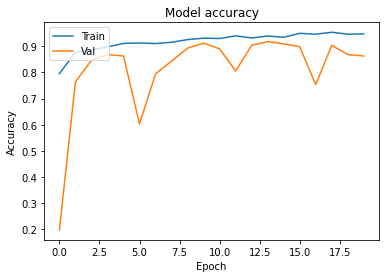

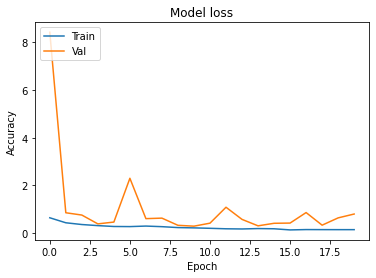

In [11]:
# Plot training loss and accuracy
history = history_aug
plt.figure()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.savefig('./results/DenseNet121_onestep_accuracy.png', dpi=150)

plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.savefig('./results/DenseNet121_onestep_loss.png', dpi=150)



In [ ]:
# img_idx = 9;
# img = train_img[img_idx,:,:,:]
# featVisualization(visualize_model, img)

In [12]:
# Save training results
f = open("./results/DenseNet121_history_aug_onestep.pkl","wb")
pickle.dump(history.history,f)
f.close()

In [ ]:
#  Load old training results
# new_history = pickle.load( open( "./results/DenseNet121_history.pkl", "rb" ) )


In [14]:
# submission
y_pred = model.predict(test_img)


submission.loc[:,'healthy':'scab'] = y_pred
submission.to_csv('DenseNet121_onestep.csv',index = False)

# PLot confusion matrix

val_pred = model.predict(X_val)

pred_index = np.argmax(val_pred,1)
y_val_index = np.argmax(y_val,1)
type(pred_index)

from sklearn.metrics import confusion_matrix, plot_confusion_matrix
confusion_matrix(y_val_index, pred_index)

array([[ 99,   0,   0,   0],
       [  2,   8,   7,   2],
       [  0,   0, 120,   0],
       [ 26,  11,   2,  88]])